In [1]:
import os
import numpy as np
from core.data_provider import datasets_factory
from core.models.model_factory import Model
from core.utils import preprocess
import core.trainer as trainer
import math 
import time
import torch
# export CUDA_VISIBLE_DEVICES=0
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/xiao/anaconda3/envs/pytorch19/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [2]:
class configs:
    is_training = 0
    device = "cuda"
    dataset_name = "motion"
    train_data_paths = "/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/multi_path_normalized_train_video.npz"
    valid_data_paths = "/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/multi_path_normalized_test_seen_video.npz"
    gen_frm_dir = "results/motion_predrnn"
    input_length = 1
    total_length = 12
    img_width = 64
    img_channel = 11
    model_name = "predrnn" #"predrnn_memory_decoupling"
    pretrained_model = "/home/xiao/Projects/STPNet/predrnn-pytorch_multipath/checkpoints/motion_predrnn/model.ckpt-24000"
#     pretrained_model = "/home/xiao/Projects/STPNet/predrnn-pytorch/checkpoints/motion_predrnn/model.ckpt-79000"
    num_hidden = "128,128,128,128"
    filter_size = 5
    stride = 1
    patch_size = 4 
    layer_norm = 0
    lr = 0.0003
    batch_size = 1
    reverse_scheduled_sampling = 0
    num_save_samples = 10
    decouple_beta = 0.1
    visual = False
    visual_path = ""

In [3]:
import matplotlib.pyplot as plt
# train_video = np.load("/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/train_video.npy")
# print ('train_video', train_video.shape)
test_seen_video = np.load("/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/multi_path_test_seen_video.npy")
test_seen_video = np.transpose(test_seen_video, (0,1,2,4,5,3))
print ('test_seen_video', test_seen_video.shape)
test_seen_config = np.load("/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/multipath_test_seen_config.npy")
video_len = test_seen_video.shape[2]
frame_size = test_seen_video.shape[3]
frame_channel = test_seen_video.shape[-1]
print ('test_seen_config', test_seen_config.shape)

test_seen_video (10, 200, 12, 64, 64, 11)
test_seen_config (100, 100, 5, 4)


[[21 43 31 47]
 [43 12 51 20]
 [45 36 49 40]
 [49 16 55 22]
 [30 42 38 50]
 [28 30 38 34]
 [ 9 48 17 56]
 [15  6 23 12]
 [16 26 20 30]
 [ 7  5 17  9]
 [14 26 24 30]
 [53 46 57 50]
 [19 31 25 35]
 [22 37 30 43]
 [42 19 50 25]]
all_obs (120, 15, 4)


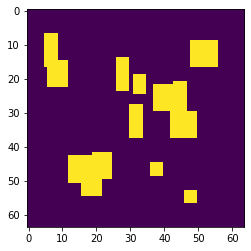

In [4]:
all_obs = np.load("/home/xiao/Projects/ST_LSTM_MP/Data/2D_map_64/Map_array/obs.npy")
print (all_obs[0])
for i in range(all_obs.shape[0]):
    for j in range(all_obs.shape[1]):
        center_x = (all_obs[i,j,0] + all_obs[i,j,2])/2
        center_y = (all_obs[i,j,1] + all_obs[i,j,3])/2
        w = abs(all_obs[i,j,0] - all_obs[i,j,2])
        h = abs(all_obs[i,j,1] - all_obs[i,j,3])
        all_obs[i,j,0] = center_x
        all_obs[i,j,1] = center_y
        all_obs[i,j,2] = w
        all_obs[i,j,3] = h
print ('all_obs', all_obs.shape)
plt.imshow(test_seen_video[0,0,0,:,:,0])

In [5]:
model = Model(configs)
model.load(configs.pretrained_model)
# model.eval() #XXXX

load model: /home/xiao/Projects/STPNet/predrnn-pytorch_multipath/checkpoints/motion_predrnn/model.ckpt-24000


In [6]:
def augmentation(img, start_x, start_y, idx):
#     start_x, start_y = np.where(img[1]==255)
    h, w = 7, 7
#     for i range(-3, 4):
#         for j in range(-3, 4):
#             x, y = start_x + i, start_y + j
#             if img[0,x,y] != 255:
#                 img[1,x,y] = 255
#     start_x, start_y = np.where(img[2]==255)
    for i in range(-3, 4):
        for j in range(-3, 4):
            x, y = start_x + i, start_y + j
            if 0<=x<=(img.shape[0]-1) and 0 <=y<=(img.shape[0]-1) and img[x,y,0]<0.1:
                img[x,y, idx] = 1.0
    return img

In [7]:
def IsInCollision(curr_x, curr_y, obs):
    cf = False
    for i in range(obs.shape[0]):
#         print ('checking obstacle', i)
        if abs(obs[i, 0] - curr_x) < obs[i,2]/2.0 and  abs(obs[i, 1] - curr_y) < obs[i,3]/2.0:
            return True
    return False

In [8]:
def reshape_tensor_patch(img_tensor, patch_size):
#     assert 5 == img_tensor.ndim
    batch_size = img_tensor.size(0)
    seq_length = img_tensor.size(1)
    img_height = img_tensor.size(2)
    img_width = img_tensor.size(3)
    num_channels = img_tensor.size(4)
    a = torch.reshape(img_tensor, [batch_size, seq_length,
                                img_height//patch_size, patch_size,
                                img_width//patch_size, patch_size,
                                num_channels])
    b = a.permute(0,1,2,4,3,5,6)
    patch_tensor = torch.reshape(b, [batch_size, seq_length,
                                  img_height//patch_size,
                                  img_width//patch_size,
                                  patch_size*patch_size*num_channels])
    return patch_tensor

In [9]:
def tensor_augmentation(img, start_x, start_y, idx):
    h, w = 7, 7
    for i in range(-3, 4):
        for j in range(-3, 4):
            x, y = start_x + i, start_y + j
            if 0<=x<=(img.size(0)-1) and 0 <=y<=(img.size(0)-1) and img[x,y,0]<0.1:
                img[x,y, idx] = 1.0
    return img

In [11]:
Threshold = 0.25
DISCRETIZATION_STEP= 0.01#0.01
max_itr = 100
max_sample = 10
success_rate = 0
all_path = []
all_time = []

test_seen_config = test_seen_config.astype(int) 

for map_id in range(100):
    print ('Testing seen map', map_id)
    obs = all_obs[map_id]
    for task_id in range(200):
        multi_sg = test_seen_config[map_id, task_id]
        print ('multi_sg', multi_sg)
        path = []
        path_flag = [0]*multi_sg.shape[0]
        for i in range(multi_sg.shape[0]):
            path.append([(multi_sg[i,0], multi_sg[i,1])])

#         print ('configuration', test_seen_config[map_id, task_id])     
        first_frame = np.copy(test_seen_video[map_id,task_id, 0])
        video = np.zeros((1,configs.total_length,frame_size,frame_size,frame_channel))# / 255.0
        video[0, :, :, :, 0] = first_frame[:,:,0]
        for i in range(1, frame_channel):
            if i%2:
                video[0, 0, :, :, i] = first_frame[:,:,i]
            else:
                video[0, :, :, :, i] = first_frame[:,:,i]
                
        video = torch.FloatTensor(video).float()
        video = video.cuda()
        
        configs.input_length = 1
        
        real_input_flag = np.zeros(
                (configs.batch_size,
                 configs.total_length - configs.input_length - 1,
                 configs.img_width // configs.patch_size,
                 configs.img_width // configs.patch_size,
                 configs.patch_size ** 2 * configs.img_channel))

        no_step = 0
        no_frame = 0
        s_time = time.time()
        while True:
            if no_step >= configs.total_length - 2:
                no_frame = configs.total_length - 2
            else:
                no_frame = no_step
                
            test_dat = reshape_tensor_patch(video, configs.patch_size)
            test_dat = test_dat.cuda()
            real_input_flag = torch.FloatTensor(real_input_flag).cuda()
            
            predicted_frame, _ = model.network(test_dat, real_input_flag)
            predicted_frame = predicted_frame.detach().cpu().numpy()
            
            predicted_frame = preprocess.reshape_patch_back(predicted_frame, configs.patch_size)           
            for agent_id in range(5):
                if path_flag[agent_id]:
                    continue
                    
                start_x, start_y = path[agent_id][0][0], path[agent_id][0][1]
                goal_x, goal_y = multi_sg[agent_id, -2], multi_sg[agent_id, -1]
                
                predicted_pos = predicted_frame[0,no_frame,:,:,agent_id]
                sample_pools = np.unravel_index(np.argsort(predicted_pos, axis=None)[::-1], predicted_pos.shape)
            
                for idx in range(sample_pools[0].shape[0]):
                    next_x, next_y = sample_pools[0][idx], sample_pools[1][idx]
                    if first_frame[next_x, next_y, 0] > 0.9 or (next_x, next_y) in path[agent_id]:
                        continue
                    #collision detection
                    last_x, last_y = path[agent_id][-1]
                    distTotal = math.sqrt((next_x - last_x)**2 + (next_y - last_y)**2)

                    collision_flag = False
                    if distTotal>0:
                        incrementTotal = distTotal/DISCRETIZATION_STEP
                        numSegments = int(math.floor(incrementTotal))     
                        x_dist = (next_x - last_x)/numSegments
                        y_dist = (next_y - last_y)/numSegments

                        for pt in range(numSegments):
                            last_x = last_x + x_dist
                            last_y = last_y + y_dist
                            
                            if first_frame[int(last_x), int(last_y), 0] > 0.9:
                                collision_flag = True
                                break

                    if not collision_flag:
                        path[agent_id].append((next_x, next_y))
                        break

                if abs(next_x - goal_x) + abs(next_y - goal_y) <= 2:
                    path_flag[agent_id] = 1
                    path[agent_id].append((goal_x, goal_y))
                    path[agent_id].append('#') #denote the path is successful
                    break

            if no_step >= configs.total_length - 2:
                video[0, :-1] = video[0, 1:].clone()
                for agent_id in range(5):
                    video[0, -2] = augmentation(video[0, -2], next_x, next_y, 2*agent_id + 1)
            else:
                for agent_id in range(5):
                    video[0, no_frame + 1] = augmentation(video[0, no_frame + 1], next_x, next_y, 2*agent_id + 1)
            
            no_step += 1
            configs.input_length = no_frame + 1
            real_input_flag = np.zeros(
                    (configs.batch_size,
                     configs.total_length - configs.input_length - 1,
                     configs.img_width // configs.patch_size,
                     configs.img_width // configs.patch_size,
                     configs.patch_size ** 2 * configs.img_channel))
#             print ('sum(path_flag)', sum(path_flag))
            if sum(path_flag) == 5:
                print ('Success!')
                success_rate += 1
                break
            if no_step > max_itr:
                print ('failed!')
                break
            all_time.append(time.time()-s_time)
    print (path)
    all_path.append(path)
    print ('sucess_rate', success_rate)
    
print ('average length', sum([len(p) for p in all_path])/len(all_path))
print ('The average time is', sum(all_time)/2000.0)
# print ('The average time is', sum(all_time)/len(all_time))
        
    

Testing seen map 0
multi_sg [[ 1 60 58 13]
 [59  2  0 56]
 [ 2 13 62 53]
 [ 5 14 58 61]
 [60  0  2 48]]
Success!
[[(1, 60), (3, 34), (0, 58), (2, 58), (0, 54), (0, 49), (3, 52), (0, 45), (2, 54), (4, 47), (4, 49), (4, 45), (3, 56), (61, 60), (59, 13), (58, 13), '#'], [(59, 2), (59, 11), (60, 50), (62, 50), (62, 54), (59, 62), (60, 54), (61, 62), (3, 56), (0, 56), '#'], [(2, 13), (1, 53), (3, 57), (60, 54), (62, 53), '#'], [(5, 14), (1, 54), (3, 55), (3, 59), (60, 55), (63, 53), (58, 9), (60, 60), (58, 61), '#'], [(60, 0), (61, 53), (56, 58), (56, 62), (59, 53), (58, 58), (60, 62), (58, 15), (60, 58), (58, 11), (55, 12), (57, 12), (58, 62), (2, 56), (1, 51), (2, 48), '#']]
sucess_rate 1
Testing seen map 1
multi_sg [[60 62 18  0]
 [13  8 60 61]
 [ 0  4 42 62]
 [51  1  1 62]
 [59  0  1 62]]
Success!
[[(60, 62), (62, 58), (58, 62), (3, 62), (4, 61), (0, 61), (41, 59), (42, 61), (62, 62), (41, 63), (60, 58), (2, 63), (58, 58), (59, 56), (59, 60), (1, 60), (4, 63), (0, 63), (45, 59), (63, 60

IndexError: index 10 is out of bounds for axis 0 with size 10